In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as functional
from torch.utils.data import Subset, Dataset
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import Generator

the idea is to use a physics informed neural network (pinn) alongside the other metrics and methods (KFCV, Adam, MSE). since I don't really understand (yet) the equations behind modelling the ocean, I'm going back to home base: laplace's equation: 

$\nabla^2 \varphi = 0$

how can a neural network learn this equation and its solutions? let's start with a simple network, trying to predict the equation through deep learning, only

first off, let's have our output data be produced by a numerical simulation using FDM. 

Let the increments in a direction $w$ be $\Delta w$. Therefore, generically, for $\nabla^2\varphi = 0$, we have $\frac{\partial^2 \varphi}{\partial w^2} = \frac{\varphi_{i + 1, j} - 2\varphi_{i,j} + \varphi_{i-1, j}}{\Delta w^2}$ if $\varphi = \varphi(w, ...)$. In two dimensions, 
$\frac{\varphi_{i+1, j} -2\varphi_{i,j} +  \varphi_{i-1,j}}{\Delta x^2} + \frac{\varphi_{i, j+1} - 2\varphi_{i,j} + \varphi_{i,j-1}}{\Delta y^2} = 0$ If $\Delta x = \Delta y$, we can solve for $\varphi_{i,j}$, such that $\varphi_{i,j} = \frac{\varphi_{i+1, j} + \varphi_{i-1, j} + \varphi_{i,j+1} + \varphi_{i,j-1}}{4}$ Numerically, we can implement a break if the method stops converging.

In [2]:
def fdmLaplace(nx, ny, lx=5, ly=5,tolerance=1e-5, maxIterations = 10000): # lx and ly are the "sizes" of our space. we're using dirichlet boundary conditions, too

    dx, dy = lx/(nx - 1), ly/(ny - 1)
    
    V = np.zeros((nx, ny))

    V[-1, :], V[0, :], V[:, 0], V[:, -1] = 0.0,0.0,0.0,1.0

    for iteration in range(maxIterations):

        oldV = V.copy()

        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                V[i, j] = 0.25 * (V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])

        if(np.max(np.abs(oldV - V)) < tolerance):
            print(f"Convergence stopped, breaking at {iteration}-th iteration.")
            break

    return V

In [3]:
lx, ly = 1, 1
nx, ny = 100, 100
potential = fdmLaplace(nx, ny, lx, ly)

Convergence stopped, breaking at 3707-th iteration.


now, to create a pinn, we have to create a class which is a bit different than i usually write these classes. 

$\mathcal{L}_{\text{Total}} = \lambda_1\mathcal{L}_{\text{Training}} + \lambda_2\mathcal{L}_{\text{Physics}} + \lambda_3\mathcal{L}_{\text{Boundary}}$

where $\lambda_j$ can be chosen as needed, but that's a bit boring and time-consuming. so, we can implement a meta-learning algorithm where the pinn learns the best lambdas for the problem at hand, creating a dynamic loss-weight pinn. 

if we want to be explicit, notice that, for laplace's equation, we expect $\nabla^2\varphi = 0$, which implies that the physics loss should be just $\mathcal L_P = \verb|torch.mean|(\nabla^2\varphi - 0)$. 

In [4]:
class LaplaceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( # this is equivalent to writing the neural network with all the fullyConnected's and tanh activation functions in the forward method
            nn.Linear(2, 64),
            nn.Tanh(), 
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        self.lambdaPhysics = nn.Parameter(torch.tensor(1.0)) # initializes the lambdas as unitary, as we assume they should have the same weight
        self.lambdaBoundary = nn.Parameter(torch.tensor(1.0))
        self.lambdaNNerror = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        self.current_x = x.clone().detach().requires_grad_(True) # this is required to check the forward pass/loss computation order 
        x = self.current_x

        return self.net(x)

    def pinnLoss(self, outputs, targets, dynamicLambda = False): # here, we define the pinnLoss method.
        if self.current_x is None:
            raise ValueError("Forward pass must be called before loss computation")
        
        # simple MSE for NN loss
        mseLoss = nn.MSELoss()(outputs, targets)

        if not torch.is_grad_enabled():
            return mseLoss

        # calculating the laplacian to calculate the physics loss
        x = self.current_x
        u = outputs # potential 

        grad = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = grad[:, 0:1]
        u_y = grad[:, 1:2]

        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

        laplacian = u_xx + u_yy
        physicsLoss = torch.mean(laplacian**2)

        # to calculate the boundary loss, we use masking to discriminate the "borders" of our space
        eps = 1e-8 # this tolerance stops some weird NaN's from appearing 
        boundary_mask = (
            (x[:, 0] <= eps) | (x[:, 0] >= 1.0 - eps) |
            (x[:, 1] <= eps) | (x[:, 1] >= 1.0 - eps)
        )

        if boundary_mask.any(): 
            boundaryLoss = nn.MSELoss()(outputs[boundary_mask], targets[boundary_mask])
        else:
            boundaryLoss = torch.tensor(0.0, device=outputs.device)
        
        return (
                1.0 * mseLoss +
                1.0 * physicsLoss +
                1.0 * boundaryLoss
            ) if dynamicLambda == False else (
            
            self.lambdaNNerror * mseLoss + 
            self.lambdaPhysics * physicsLoss + 
            self.lambdaBoundary * boundaryLoss
            
            ) # this implements the option of dynamicLambdas



In [5]:
def generate_points(nInterior=10000, n_boundary=400): # this functions is just used to generate points for the space. i changed the naming convention to make reading easier. 
    # internal points
    x_in = np.random.rand(nInterior, 2)

    # checking boundary coordinates. notice that each x is a (x,y) type object
    
    x_b1 = np.column_stack((np.zeros(n_boundary), np.random.rand(n_boundary)))       # x = 0
    x_b2 = np.column_stack((np.ones(n_boundary), np.random.rand(n_boundary)))        # x = 1
    x_b3 = np.column_stack((np.random.rand(n_boundary), np.zeros(n_boundary)))       # y = 0
    x_b4 = np.column_stack((np.random.rand(n_boundary), np.ones(n_boundary)))        # y = 1

    x_b = np.vstack((x_b1, x_b2, x_b3, x_b4))

    # boundary values. it's easier to just take V = 0 at the boundaries. 
    u_b = np.vstack((
        np.zeros((n_boundary, 1)),     # x = 0
        np.ones((n_boundary, 1)),      # x = 1
        np.zeros((n_boundary, 1)),     # y = 0
        np.zeros((n_boundary, 1))      # y = 1
    ))

    return x_in, x_b, u_b

In [6]:
def train(model, x_in, x_b, borderPotential, interiorPotential, epochs=5000, lrParams=1e-3, lrLambdas=1e-4, dynamicLambda = False): # the train function needed some heavy tweaks too 
    xAll = torch.tensor(np.vstack((x_in, x_b)), dtype=torch.float32)   # all of the points 
    yAll = torch.tensor(np.vstack((interiorPotential, borderPotential)), dtype=torch.float32)  # all of the potentials


    # here, we discriminate between neural-network parameters and lambda values for custom loss functions
    
    paramsNN = [p for n, p in model.named_parameters() if not n.startswith('lambda')] 
    paramsLambda = [p for n, p in model.named_parameters() if n.startswith('lambda')]

    optimizer = torch.optim.Adam([
        {'params': paramsNN, 'lr': lrParams},
        {'params' : paramsLambda, 'lr' : lrLambdas}
        
    ]) if dynamicLambda != False else torch.optim.Adam([{'params': paramsNN, 'lr': lrParams}]) # we can choose to not meta-learn the lambdas by setting dynamicLambda = False (default)

    for epoch in range(epochs):
        optimizer.zero_grad()

        yPred = model(xAll)
        
        loss = model.pinnLoss(yPred, yAll, dynamicLambda)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch} \t Loss: {loss.item():.4f} \t Lambda_NN: {model.lambdaNNerror.item():.4f} \t Lambda_Phys: {model.lambdaPhysics.item():.4f} \t Lambda_BC: {model.lambdaBoundary.item():.4f}")

    return model # returns trained model

In [7]:
def evaluate(model, res=1000): # simple function to evaluate the model using a simple grid from 0,1 with res points. 
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)
    xx, yy = np.meshgrid(x, y)
    pts = np.column_stack((xx.ravel(), yy.ravel()))
    pts_tensor = torch.tensor(pts, dtype=torch.float32)
    with torch.no_grad():
        u = model(pts_tensor).numpy().reshape((res, res))
    return xx, yy, u

In [8]:
model = LaplaceModel()
x_in, x_b, borderPotential = generate_points()  # generates the points 
uInside = np.zeros((len(x_in), 1))  # potential inside the region
trained_model = train(model, x_in, x_b, borderPotential, uInside, epochs = 10000, dynamicLambda = True)
xx, yy, uu = evaluate(trained_model)

Epoch 0 	 Loss: 0.2666 	 Lambda_NN: 0.9999 	 Lambda_Phys: 0.9999 	 Lambda_BC: 0.9999
Epoch 100 	 Loss: 0.1591 	 Lambda_NN: 0.9897 	 Lambda_Phys: 0.9957 	 Lambda_BC: 0.9908
Epoch 200 	 Loss: 0.1340 	 Lambda_NN: 0.9796 	 Lambda_Phys: 0.9917 	 Lambda_BC: 0.9820
Epoch 300 	 Loss: 0.1117 	 Lambda_NN: 0.9695 	 Lambda_Phys: 0.9867 	 Lambda_BC: 0.9751
Epoch 400 	 Loss: 0.1072 	 Lambda_NN: 0.9590 	 Lambda_Phys: 0.9833 	 Lambda_BC: 0.9689
Epoch 500 	 Loss: 0.1034 	 Lambda_NN: 0.9484 	 Lambda_Phys: 0.9809 	 Lambda_BC: 0.9626
Epoch 600 	 Loss: 0.1009 	 Lambda_NN: 0.9379 	 Lambda_Phys: 0.9783 	 Lambda_BC: 0.9561
Epoch 700 	 Loss: 0.0997 	 Lambda_NN: 0.9274 	 Lambda_Phys: 0.9752 	 Lambda_BC: 0.9494
Epoch 800 	 Loss: 0.0972 	 Lambda_NN: 0.9170 	 Lambda_Phys: 0.9717 	 Lambda_BC: 0.9426
Epoch 900 	 Loss: 0.0958 	 Lambda_NN: 0.9065 	 Lambda_Phys: 0.9682 	 Lambda_BC: 0.9355
Epoch 1000 	 Loss: 0.0944 	 Lambda_NN: 0.8962 	 Lambda_Phys: 0.9645 	 Lambda_BC: 0.9282
Epoch 1100 	 Loss: 0.0932 	 Lambda_NN: 0.885

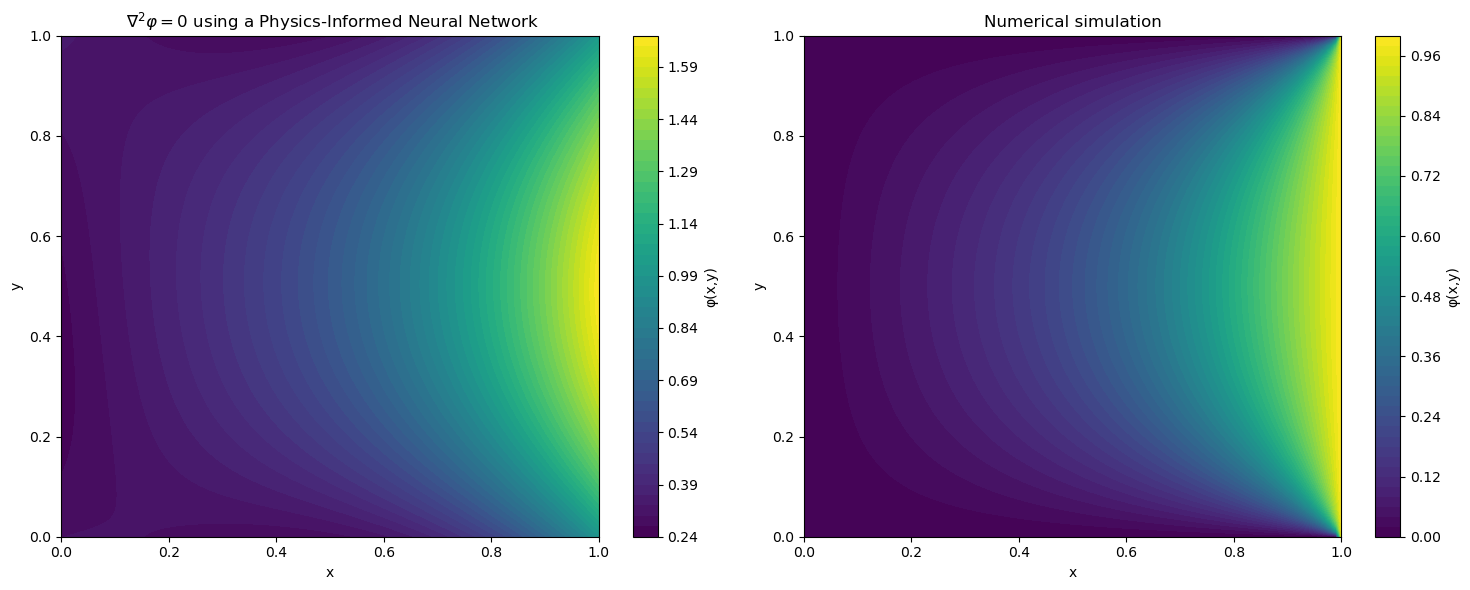

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

im1 = ax1.contourf(xx, yy, uu, levels=50, cmap="viridis")
#ax1.colorbar(label='φ(x, y)')
ax1.set_title(" $∇^2φ= 0$ using a Physics-Informed Neural Network")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

fig.colorbar(im1, ax = ax1, label="φ(x,y)")

im2 = ax2.contourf(np.linspace(0, 1, 100), 
                 np.linspace(0, 1, 100), 
                 potential, 
                 levels=50, 
                 cmap="viridis")

ax2.set_title("Numerical simulation")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(im2, ax = ax2, label="φ(x,y)")

plt.tight_layout()
plt.show()

so, clearly, the general _aspect_ of the simulation looks the same. the problem is the scale; the scale is a bit wrong on the pinn estimations, which is defintely something to be worked on and though about. anyways, the initial idea was to simply implement a pinn with a known equation. 